<a href="https://colab.research.google.com/github/tathagat2000/practice/blob/master/Ashrae1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as PLT
from matplotlib import image as mpimg
import scipy
from scipy import misc
import imageio
import os
import keras
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import drive 
drive.mount('/mntDrive') 

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


In [0]:
path = "/mntDrive/My Drive/Kaggle_Ashrae_Data/building_metadata.csv"
#test=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/test.csv")
train=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/train.csv")
building=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/building_metadata.csv")
#weather_test=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/weather_test.csv")
weather_train=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/weather_train.csv")

train = train.fillna(0)
weather_train = weather_train.fillna(0)
building = building.fillna(0)


In [0]:
train = train.merge(building, how='left' , on='building_id' )
train = train.merge(weather_train , how='left' , left_on=['site_id' , 'timestamp'], right_on=['site_id' , 'timestamp'])
y_train = train.iloc[:,3]



In [0]:

train.count()

building_id           20216100
meter                 20216100
timestamp             20216100
meter_reading         20216100
site_id               20216100
primary_use           20216100
square_feet           20216100
year_built            20216100
floor_count           20216100
air_temperature       20125605
cloud_coverage        20125605
dew_temperature       20125605
precip_depth_1_hr     20125605
sea_level_pressure    20125605
wind_direction        20125605
wind_speed            20125605
dtype: int64

In [0]:
train = train.drop(train.columns[[0,3,4]] , axis=1)

In [0]:
train.count()

meter                 20216100
timestamp             20216100
primary_use           20216100
square_feet           20216100
year_built            20216100
floor_count           20216100
air_temperature       20125605
cloud_coverage        20125605
dew_temperature       20125605
precip_depth_1_hr     20125605
sea_level_pressure    20125605
wind_direction        20125605
wind_speed            20125605
dtype: int64

In [0]:
train = train.fillna(0)

In [0]:
(pd.unique(train.iloc[:,0]))

array([0, 3, 1, 2], dtype=uint64)

In [0]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use'])

In [0]:
1

1

In [0]:
onehot = pd.get_dummies(train.meter)
train = pd.concat([train, onehot], axis=1)

In [0]:
onehot = pd.get_dummies(train.primary_use)
train = pd.concat([train, onehot], axis=1)

In [0]:
train = train.drop(train.columns[[0,2]] , axis=1)

In [0]:
train1=train

In [0]:
train1

,timestamp,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,0,1,2,3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2016-01-01 00:00:00,7432,2008.0,-999.0,25.0,6.0,20.0,-999.0,1019.7,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-01-01 00:00:00,2720,2004.0,-999.0,25.0,6.0,20.0,-999.0,1019.7,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 00:00:00,5376,1991.0,-999.0,25.0,6.0,20.0,-999.0,1019.7,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-01-01 00:00:00,23685,2002.0,-999.0,25.0,6.0,20.0,-999.0,1019.7,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 00:00:00,116607,1975.0,-999.0,25.0,6.0,20.0,-999.0,1019.7,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,2016-12-31 23:00:00,19619,1914.0,-999.0,1.7,-999.0,-5.6,-1.0,1008.5,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20216096,2016-12-31 23:00:00,4298,-999.0,-999.0,1.7,-999.0,-5.6,-1.0,1008.5,180.0,8.8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20216097,2016-12-31 23:00:00,11265,1997.0,-999.0,1.7,-999.0,-5.6,-1.0,1008.5,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20216098,2016-12-31 23:00:00,29775,2001.0,-999.0,1.7,-999.0,-5.6,-1.0,1008.5,180.0,8.8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
timestamp = train.iloc[:,0]

In [0]:
timestamp

0           2016-01-01 00:00:00
1           2016-01-01 00:00:00
2           2016-01-01 00:00:00
3           2016-01-01 00:00:00
4           2016-01-01 00:00:00
                   ...         
20216095    2016-12-31 23:00:00
20216096    2016-12-31 23:00:00
20216097    2016-12-31 23:00:00
20216098    2016-12-31 23:00:00
20216099    2016-12-31 23:00:00
Name: timestamp, Length: 20216100, dtype: object

In [0]:
train = train.drop(train.columns[[0]],axis=1)

In [0]:
timestamp = pd.to_datetime(timestamp)

In [0]:
train = pd.concat([train ,  (timestamp.dt.weekday)] , axis=1)
train = pd.concat([train ,(timestamp.dt.hour)] , axis=1 )

In [0]:
new = timestamp.str.split("-", n = 3, expand = True) 

In [0]:
month=new[1]
time=new[2]

In [0]:
train=pd.concat([train,month] , axis=1)

In [0]:
new = time.str.split(" ", n = 2, expand = True) 

In [0]:
day = new[0]
time = new[1]

In [0]:
train=pd.concat([train,day] , axis=1)

In [0]:
new = time.str.split(":" , n=1, expand=True)

In [0]:

train = pd.concat([train,new[0]] , axis=1)
del new
del day
del month
del time
import gc
gc.collect()

12

In [0]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [0]:
train , NAlist = reduce_mem_usage(train)
weather_train , NAlist = reduce_mem_usage(weather_train)
building , NAlist = reduce_mem_usage(building)




Memory usage of properties dataframe is : 616.946533203125  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  289.19375228881836  MB
This is  46.87501051142198 % of the initial size
Memory usage of properties dataframe is : 9.597572326660156  MB
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  air_temperature
dtype before: 

In [0]:
month = pd.get_dummies(train1.iloc[:,30])
day = pd.get_dummies(train1.iloc[:,31])
hour = pd.get_dummies(train1.iloc[:,32])

In [0]:
train1 = pd.concat([train1,month] , axis=1)
train1 = pd.concat([train1,day] , axis=1)
train1 = pd.concat([train1,hour] , axis=1)


NameError: ignored

In [0]:
train

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,0,1,2,3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,timestamp,timestamp
0,7432,2008,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
1,2720,2004,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
2,5376,1991,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
3,23685,2002,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,116607,1975,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,19619,1914,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,23
20216096,4298,0,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,23
20216097,11265,1997,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,23
20216098,29775,2001,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,23


In [0]:
onehot=pd.get_dummies(train.iloc[:,30])
onehot1 = pd.get_dummies(train.iloc[:,31])
train = train.drop(train.columns[[30,31]] , axis=1)
train = pd.concat([train,onehot] , axis=1)
train = pd.concat([train , onehot1] , axis=1)


In [0]:
del train["timestamp"]

In [0]:
train

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,0,1,2,3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,7432,2008,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2720,2004,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5376,1991,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23685,2002,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,116607,1975,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,19619,1914,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216096,4298,0,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216097,11265,1997,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216098,29775,2001,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
train = scaler.fit_transform(train)

In [0]:
targetscaler  =preprocessing.StandardScaler()
y_train = targetscaler.fit_transform(y_train)

ValueError: ignored

In [0]:
import math

def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

In [0]:
from keras import Sequential
from keras.layers import Dense

def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=61, input_dim=61))
    regressor.add(Dense(units=128))
    regressor.add(Dense(units=256))
    regressor.add(Dense(units=1))
    #regressor.add(Dense(units=2048))
    #regressor.add(Dense(units=4096))
    #regressor.add(Dense(units=1))
    #regressor.add(Dense(units=8192))
    #regressor.add(Dense(units=8192))
    #regressor.add(Dense(units=1))
    #regressor.add(Dense(units=8))
    #regressor.add(Dense(units=4))
    #regressor.add(Dense(units=1))
    regressor.compile(optimizer= 'adam' , loss='mean_squared_logarithmic_error',  metrics=['mean_squared_error'])
    return regressor


In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

regressor = KerasRegressor(build_fn=build_regressor, batch_size=1024,epochs=20)

In [0]:
results=regressor.fit(train,y_train)

Epoch 1/20
20216100/20216100 [==============================] - 144s 7us/step - loss: 3.8435 - mean_squared_error: 23484469144.7173
Epoch 2/20
20216100/20216100 [==============================] - 143s 7us/step - loss: 3.7789 - mean_squared_error: 23484448506.1920
Epoch 3/20
20216100/20216100 [==============================] - 143s 7us/step - loss: 3.7769 - mean_squared_error: 23484443821.0759
Epoch 4/20
15649792/20216100 [======================>.......] - ETA: 32s - loss: 3.7754 - mean_squared_error: 23493628114.1938

KeyboardInterrupt: ignored

In [0]:
from sklearn.linear_model import LinearRegression 
regr = LinearRegression() 

In [0]:
regr.fit(train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
regr.score(train,y_train)

0.0017362322681615527

In [0]:
model = regressor

In [0]:
from keras.models import load_model

model.model.save("/mntDrive/My Drive/Kaggle_Ashrae_Data/nn_classifier_linear.h5")


In [0]:
train

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,0,1,2,3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,7432,2008,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2720,2004,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5376,1991,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23685,2002,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,116607,1975,0,25.0,6.0,20.0,0.0,1019.700012,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,19619,1914,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216096,4298,0,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216097,11265,1997,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20216098,29775,2001,0,1.7,0.0,-5.6,-1.0,1008.500000,180.0,8.8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
test

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [0]:
y_train.median()

78.7750015258789

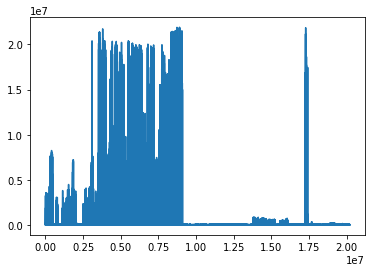

In [0]:
import matplotlib.pyplot as plt

plt.plot(y_train)